# Re-Attempt at Local Fitting Scheme

In [1]:
import numpy as np
import utils
import evolutionTools as evt
import cv2
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def place_x_nodes(interval = (0, 575), n_nodes = evt.N + 2):
    start, end = interval
    N = n_nodes
    if N == 1:
        return [start]
    elif N == 2:
        return [start, end]
    
    step = (end - start) // (N - 1)
    
    # Generate nodes
    nodes = [start + i * step for i in range(N)]
    
    # Ensure the last element is exactly the end
    nodes[-1] = end
    
    return np.array(nodes)

In [3]:
def get_upper_waveform(video_name, image_number, OUTPUT = False):   #no path - just number
    image_path = "Data/video"+video_name+"_TREATED/"+"image"+ str(image_number) +".jpg"
    frame = cv2.imread(image_path)
    frame = utils.image_processing(frame) #To get two dimensional array instead of 3 (Grayscale)
    
    waveform = utils.get_waveform(frame) #Upper and Lower surfaces
    upper_surface = waveform[:, 0]

    #plt.plot(np.arange(utils.width), middle_line, label = "middle")     # CAN CHANGE
    #plt.show()
    
    return upper_surface

In [4]:
def interpolate(x, y, u):
    # Extrapolation for u less than x[0]
    if u < x[0]:
        x_i, x_ip1 = x[0], x[1]
        y_i, y_ip1 = y[0], y[1]
        v = y_i + ((u - x_i) * (y_ip1 - y_i)) / (x_ip1 - x_i)
        return v

    # Extrapolation for u greater than x[-1]
    if u > x[-1]:
        x_i, x_ip1 = x[-2], x[-1]
        y_i, y_ip1 = y[-2], y[-1]
        v = y_i + ((u - x_i) * (y_ip1 - y_i)) / (x_ip1 - x_i)
        return v

    # Interpolation for u within the bounds
    for i in range(len(x) - 1):
        if x[i] <= u <= x[i + 1]:
            x_i, x_ip1 = x[i], x[i + 1]
            y_i, y_ip1 = y[i], y[i + 1]
            v = y_i + ((u - x_i) * (y_ip1 - y_i)) / (x_ip1 - x_i)
            return v
    
    # If the code reaches here, it means something went wrong
    raise RuntimeError("Interpolation error")


In [5]:
def segment_energy(x_ext, y_ext, initial_length, stiffness, x_nodes, y_nodes):
    total_length = 0
    current_point = (x_ext[0], y_ext[0])
    end_point = (x_ext[1], y_ext[1])
    for i in range(x_nodes.shape[0]):
        if current_point[0] <= x_nodes[i] <= end_point[0]:
            total_length += evt.euclideanDistance(current_point, (x_nodes[i], y_nodes[i]))
            current_point = (x_nodes[i], y_nodes[i])
        if x_nodes[i] > end_point[0]:
            break
    total_length += evt.euclideanDistance(current_point, end_point)
    return 0.5 * stiffness * ((initial_length - total_length)**2)

In [6]:
def potential_energy(u_arr, x, y, lengths, k):
    u = np.zeros(x.shape[0])
    for j in range(u_arr.shape[0]):
        u[j+1] = u_arr[j] 
    new_x = x + u
    new_y = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        new_y[i] = interpolate(x, y, new_x[i])
    segment_energies = np.zeros(k.shape[0])
    for l in range(segment_energies.shape[0]):
        segment_energies[l] = segment_energy(new_x[l:l+2], new_y[l:l+2], lengths[l], k[l], x, y)
    energy = np.sum(segment_energies)
    return energy
    


In [7]:
def get_frame_potential(video_name, image_number, initial_lengths, K_arr, initial_guess, x_nodes):
    waveform = get_upper_waveform(video_name, image_number)
    y_nodes = waveform[x_nodes]
    disp = minimize(
        potential_energy,
        initial_guess,
        args = (x_nodes, y_nodes, initial_lengths, K_arr)
        )
    displacements = disp.x
    energy = potential_energy(displacements, x_nodes, y_nodes, initial_lengths, K_arr)
    return energy, displacements

In [8]:
def potential_evolution(video_name, total_images, increment = 1):
    image_number = 1
    x_nodes = place_x_nodes((0, 575), evt.N +  2)
    waveform = get_upper_waveform(video_name, image_number)
    y_nodes = waveform[x_nodes]
    initial_lengths = evt.initialLengthsFinder(x_nodes, y_nodes)
    #print(initial_lengths)
    #print(f'Initial lengths: {initial_lengths}')
    stiffnesses = np.ones(evt.N+1)/(initial_lengths)
    energy_array = np.zeros(total_images)
    initial_guess = np.zeros(evt.N)
    displacements = []
    while image_number <= total_images:
       print(f'Processing Frame: {image_number}  ')
       new_energy, displacement = get_frame_potential(video_name,
                                                       image_number,
                                                       initial_lengths,
                                                       stiffnesses,
                                                       initial_guess,
                                                       x_nodes)
       energy_array[image_number - 1] = new_energy
       print(f'Frame Energy = {new_energy}')
       displacements.append(deepcopy(displacement))
       initial_guess = displacement
       image_number += increment
    return energy_array, np.array(displacements)
    

In [9]:
energy, displacements = potential_evolution(video_name="007MA_Left_20160304_140907.avi", total_images=139, increment=1)

Processing Frame: 1  
Frame Energy = 0.0
Processing Frame: 2  
Frame Energy = 0.0005813569696338973
Processing Frame: 3  
Frame Energy = 0.0005149260944394613
Processing Frame: 4  
Frame Energy = 0.0002666459418772841
Processing Frame: 5  
Frame Energy = 0.00021565765946815428
Processing Frame: 6  
Frame Energy = 0.0003175783923058037
Processing Frame: 7  
Frame Energy = 0.0037521169820080563
Processing Frame: 8  
Frame Energy = 0.001701820265081288
Processing Frame: 9  
Frame Energy = 0.0013325507661183537
Processing Frame: 10  
Frame Energy = 3.8355106955031245e-05
Processing Frame: 11  
Frame Energy = 0.0017852758583557816
Processing Frame: 12  
Frame Energy = 0.0010711724733593862
Processing Frame: 13  
Frame Energy = 0.0010501784356256533
Processing Frame: 14  
Frame Energy = 0.001650411869485861
Processing Frame: 15  
Frame Energy = 0.0013991796388074919
Processing Frame: 16  
Frame Energy = 0.0005592264255907463
Processing Frame: 17  
Frame Energy = 0.00035142385987330484
Proces

In [12]:
np.argmax(energy)

102

In [14]:
filtered_energy = np.array([i for i in energy if i != energy[102]])

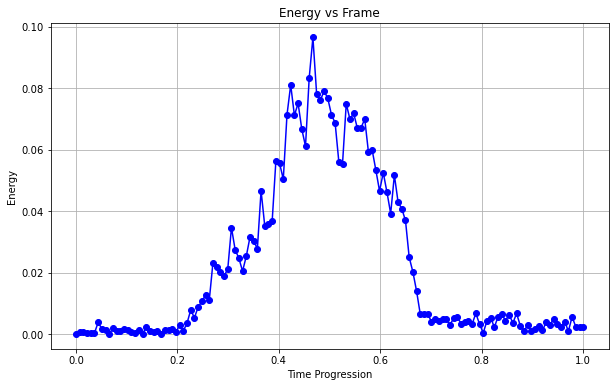

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0,1, filtered_energy.shape[0]), filtered_energy, marker='o', linestyle='-', color='b')
plt.xlabel('Time Progression')
plt.ylabel('Energy')
plt.title('Energy vs Frame')
plt.grid(True)
plt.show()
